# Reusable workflows

Nipype doesn't just allow you to create your own workflows. It also already comes with predefined workflows, developed by the community, for the community. For a full list of all workflows, look under the [Workflows](http://nipype.readthedocs.io/en/latest/documentation.html) section of the main homepage.

But to give you a short overview, there are workflows about:

**Functional MRI** workflows:
 - from **``fsl``** about ``resting state``, ``fixed_effects``, ``modelfit``, ``featreg``, ``susan_smooth`` and many more
 - from **``spm``** about ``DARTEL`` and ``VBM``

**Structural MRI** workflows
 - from **``ants``** about ``ANTSBuildTemplate`` and ``antsRegistrationBuildTemplate``
 - from **``freesurfer``** about ``bem``, ``recon`` and tessellation
 
**Diffusion** workflows:
 - from **``camino``** about ``connectivity_mapping``,  ``diffusion`` and  ``group_connectivity``
 - from **``dipy``** about ``denoise``
 - from **``fsl``** about ``artifacts``, ``dti``, ``epi``, ``tbss`` and many more
 - from **``mrtrix``** about ``connectivity_mapping``, ``diffusion`` and ``group_connectivity``

# How to load a workflow from Nipype

Let's consider the example of a functional MRI workflow, that uses FSL's Susan algorithm to smooth some data. To load such a workflow, we only need the following command:

In [ ]:
from nipype.workflows.fmri.fsl.preprocess import create_susan_smooth
smoothwf = create_susan_smooth()

Once a workflow is created, we need to make sure that the mandatory inputs are specified. To see which inputs we have to define, we can use the command:

``create_susan_smooth?``

Which gives us the output:

```
Create a SUSAN smoothing workflow

Parameters
----------
Inputs:
    inputnode.in_files : functional runs (filename or list of filenames)
    inputnode.fwhm : fwhm for smoothing with SUSAN
    inputnode.mask_file : mask used for estimating SUSAN thresholds (but not for smoothing)

Outputs:
    outputnode.smoothed_files : functional runs (filename or list of filenames)
```

As we can see, we also need a mask file. For the sake of convenience, let's take the mean image of a functional image and threshold it at the 50% percentil:

In [ ]:
!fslmaths /data/ds102/sub-01/func/sub-01_task-flanker_run-1_bold.nii.gz \
    -Tmean -thrP 50 /data/ds102/sub-01/func/mask.nii.gz

Now, we're ready to finish up our smooth workflow.

In [ ]:
smoothwf.inputs.inputnode.in_files = '/data/ds102/sub-01/func/sub-01_task-flanker_run-1_bold.nii.gz'
smoothwf.inputs.inputnode.mask_file = '/data/ds102/sub-01/func/mask.nii.gz'
smoothwf.inputs.inputnode.fwhm = 4
smoothwf.base_dir = '/data'

Before we run it, let's visualize the graph:

Populating the interactive namespace from numpy and matplotlib
170301-22:02:29,361 workflow INFO:
	 Converting dotfile: /data/susan_smooth/graph.dot to png format


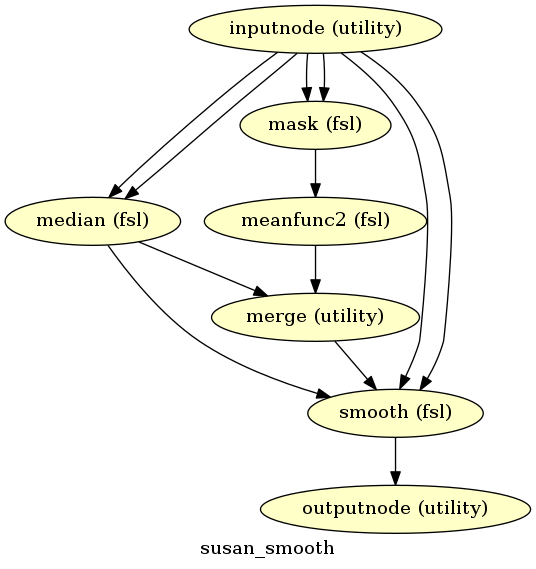

In [ ]:
%pylab inline
from IPython.display import Image
smoothwf.write_graph(graph2use='colored', format='png', simple_form=True)
Image(filename='/data/susan_smooth/graph.dot.png')

And we're ready to go:

In [ ]:
smoothwf.run('MultiProc', plugin_args={'n_procs': 4})

Once it's finished, we can look at the results:

In [ ]:
!fslmaths /data/ds102/sub-01/func/sub-01_task-flanker_run-1_bold.nii.gz -Tmean fmean.nii.gz
!fslmaths /data/susan_smooth/smooth/mapflow/_smooth0/sub-01_task-flanker_run-1_bold_smooth.nii.gz \
    -Tmean smean.nii.gz

from nilearn import image, plotting
plotting.plot_epi(
    'fmean.nii.gz', title="mean (no smoothing)", display_mode='z',
    cmap='gray', cut_coords=(-15, -5, 5, 15, 25, 35))
plotting.plot_epi(
    'smean.nii.gz', title="mean (susan smoothed)", display_mode='z',
    cmap='gray', cut_coords=(-15, -5, 5, 15, 25, 35))

# How to change node parameters from existing workflows

What if we want to change certain parameters of a loaded or already existing workflow? Let's first get the names of all the nodes in the workflow:

In [ ]:
print(smoothwf.list_node_names())

['inputnode', 'mask', 'meanfunc2', 'median', 'merge', 'outputnode', 'smooth']


Ok. Hmm, what if we want to change the 'median' node, from 50% to 60%? For this, we first need to get the node.

In [ ]:
median = smoothwf.get_node('median')

Now that we have the node, we can change it's value as we want:

In [ ]:
median.inputs.op_string = '-k %s -p 99'

And we can run the workflow again...

In [ ]:
smoothwf.run('MultiProc', plugin_args={'n_procs': 4})

And now the output is:

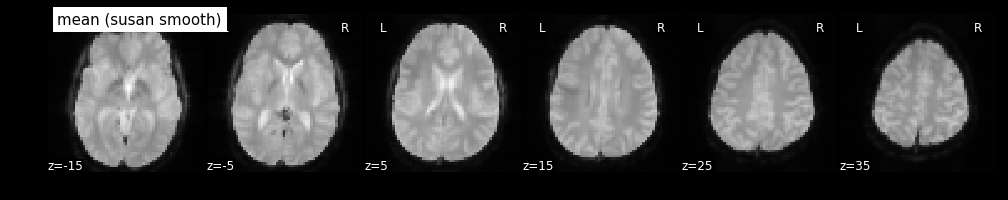

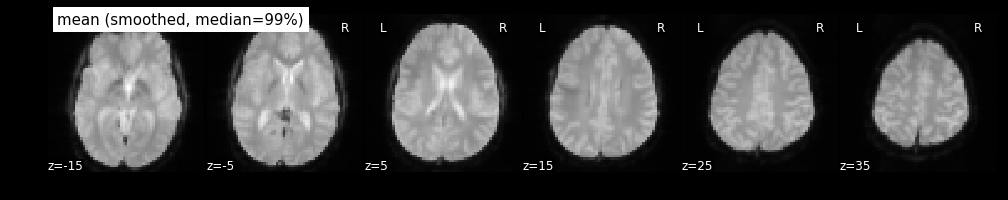

In [ ]:
!fslmaths /data/susan_smooth/smooth/mapflow/_smooth0/sub-01_task-flanker_run-1_bold_smooth.nii.gz \
    -Tmean mmean.nii.gz

from nilearn import image, plotting
plotting.plot_epi(
    'smean.nii.gz', title="mean (susan smooth)", display_mode='z',
    cmap='gray', cut_coords=(-15, -5, 5, 15, 25, 35))
plotting.plot_epi(
    'mmean.nii.gz', title="mean (smoothed, median=99%)", display_mode='z',
    cmap='gray', cut_coords=(-15, -5, 5, 15, 25, 35))